- Заповнити пропуски у коді.
- Навчити нейронну мережу.
- Побудувати необхідні графіки.
- Знайти втрати мережі.
- Протестувати роботу мережі на тестових даних.
- Виведіть метрики якості для кожного класу навченої моделі, використовуючи https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
- Зробити висновки.

# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf           # Бібліотека для створення, навчання та використання нейронних мереж
import numpy as np                # Бібліотека для роботи з багатовимірними масивами та математичними операціями
import pandas as pd               # Бібліотека для обробки та аналізу табличних даних
import matplotlib.pyplot as plt   # Модуль для побудови графіків і візуалізації даних
import random                     # Модуль для роботи з випадковими числами (генерація, перемішування тощо)
import keras as K                 # Високорівнева бібліотека для нейронних мереж, яка працює поверх TensorFlow
import seaborn as sns             # Бібліотека для створення статистичних графіків та візуалізацій даних
from sklearn.metrics import confusion_matrix        # Функція для обчислення матриці помилок (матриці неточностей класифікації)
from sklearn.metrics import classification_report   # Функція для виводу звіту з точністю, повнотою та F1-мірою для кожного класу

In [2]:
# Фіксація випадковості
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [3]:
num_classes = 10                  # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784                # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001             # швидкість навчання нейронної мережі
training_steps = 3000             # максимальне число епох
batch_size = 256                  # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100                # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128                  # кількість нейронів 1-го шару
n_hidden_2 = 256                  # кількість нейронів 2-го шару

In [4]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет MNIST
# x_train, y_train – навчальні дані (зображення і мітки)
# x_test, y_test – тестові дані (зображення і мітки)
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні значення пікселів (0-255) у формат float32
# (це необхідно для нормалізації, щоб далі працювати з числами від 0 до 1)
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
# reshape([-1, num_features]) означає: змінюємо лише другу вимірність, перша (-1) підлаштовується автоматично
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів, щоб вони знаходилися в діапазоні [0,1]
# Це допомагає швидшому та стабільнішому навчанню нейромережі
x_train, x_test = x_train / 255., x_test / 255.

# Перетворюємо навчальні дані у формат, що підтримує TensorFlow для ефективної обробки
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))

# Повторюємо датасет (щоб можна було проходити по ньому більше одного разу)
# Перемішуємо дані (shuffle(5000)), щоб навчання було більш ефективним
# Ділимо на пакети (batch_size), щоб модель навчалася на менших підмножинах (mini-batch training)
# prefetch(1) використовується для оптимізації (попереднє завантаження наступного пакета)
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
  def __init__(self, in_features, out_features, name=None):
    """
    Ініціалізація повнозв’язного (Dense) шару.
    :param in_features: Кількість входів (вхідних нейронів)
    :param out_features: Кількість виходів (вихідних нейронів)
    :param name: Ім'я шару (необов'язковий параметр)
    """
    super().__init__(name=name)

    # Ініціалізуємо ваги випадковими значеннями з нормального розподілу
    self.w = tf.Variable(
      tf.random.normal([in_features, out_features]), name="w"
    )

    # Ініціалізуємо зміщення (bias) нулями
    self.b = tf.Variable(tf.zeros([out_features]), name="b")

  def __call__(self, x, activation=0):
    """
    Виклик шару для обчислення вихідного значення.
    :param x: Вхідний тензор
    :param activation: Тип активаційної функції (0 - sigmoid, 1 - softmax)
    :return: Оброблений тензор після застосування ваг, зміщень та активаційної функції
    """
    y = tf.matmul(x, self.w) + self.b  # Лінійне перетворення: Wx + b

    if activation != 0:
      return tf.nn.softmax(y)  # Використання softmax-активації (для багатокласової класифікації)
    else:
      return tf.nn.sigmoid(y)  # Використання сигмоїдальної активації (для бінарної класифікації)


class NN(tf.Module):
  def __init__(self, name=None):
    """
    Ініціалізація нейронної мережі.
    :param name: Ім'я моделі (необов'язковий параметр)
    """
    super().__init__(name=name)

    # Перший прихований шар
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)

    # Другий прихований шар
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)

    # Вихідний шар
    self.layer_3 = DenseLayer(in_features=n_hidden_2, out_features=num_classes)

  def __call__(self, x):
    """
    Пряме поширення через шари нейронної мережі.
    :param x: Вхідні дані (тензор)
    :return: Вихідний тензор після проходження через усі шари
    """

    # Прохід через перший шар (без активації softmax, можливо, sigmoid)
    x1 = self.layer_1(x, activation=0)

    # Прохід через другий шар
    x2 = self.layer_2(x1, activation=0)

    # Прохід через вихідний шар з активацією softmax (для класифікації)
    x3 = self.layer_3(x2, activation=1)

    # Важливо! Використання softmax на вихідному шарі дозволяє отримати ймовірності
    # належності кожного вхідного об'єкта до одного з класів (від 0 до 1).

    return x3

In [6]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
# Функція для обчислення крос-ентропії
def cross_entropy(y_pred, y_true):
  # Закодувати мітки (labels) у one-hot вектор. Це необхідно, щоб мати можливість порівняти
  # кожен клас окремо з відповідними ймовірностями передбачення.
  y_true = tf.one_hot(y_true, depth=num_classes)

  # Обмежуємо значення передбачених ймовірностей, щоб уникнути помилки log(0).
  # Встановлюємо мінімальне значення для ймовірності на 1e-9, щоб гарантувати, що
  # ми не будемо застосовувати log до нуля.
  y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

  # Обчислення крос-ентропії: для кожного класу беремо відповідну ймовірність,
  # застосовуємо log, множимо на значення у one-hot векторі та підсумовуємо по всіх класах.
  # Остання частина - це середнє значення по всіх прикладах в партії (batch).
  return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Функція для обчислення точності (accuracy)
def accuracy(y_pred, y_true):
  # Ініціалізуємо об'єкт для обчислення точності
  acc = tf.metrics.Accuracy()

  # Оновлюємо стан метрики, порівнюючи справжні мітки з передбаченими класами
  # Використовуємо tf.argmax для отримання індексу класу з максимальним значенням ймовірності
  acc.update_state(y_true, tf.argmax(y_pred, axis=1))

  # Повертаємо результат точності, що є середнім значенням точності за всіма прикладами в батчі.
  return acc.result()

In [7]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

  # Отримаємо список оптимізованих параметрів
  trainable_vars = neural_net.trainable_variables  # Це ваги, які оптимізуємо
  # Обчислимо за ними значення градієнта
  gradients = g.gradient(loss, trainable_vars)

  # Модифікуємо параметри
  optimizer.apply_gradients(zip(gradients, trainable_vars))  # Застосовуємо градієнти

  return loss  # Повертаємо значення втрат для моніторингу

In [8]:
# Тренування мережі

loss_history = []     # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
  # Оновлюємо ваги нейронної мережі
  loss = train(neural_net, batch_x, batch_y)  # викликаємо функцію тренування

  if step % display_step == 0:
    pred = neural_net(batch_x)            # отримуємо передбачення для поточного батчу
    acc = accuracy(pred, batch_y)         # обчислюємо точність на поточному батчі

    # Зберігаємо значення втрат і точності
    loss_history.append(loss.numpy())     # перетворюємо тензор на число
    accuracy_history.append(acc.numpy())  # перетворюємо тензор на число

    print(f"Step {step}/{training_steps}, Loss: {loss.numpy()}, Accuracy: {acc.numpy()}")

Step 100/3000, Loss: 298.05084228515625, Accuracy: 0.7109375
Step 200/3000, Loss: 215.3596649169922, Accuracy: 0.80859375
Step 300/3000, Loss: 216.06484985351562, Accuracy: 0.8125
Step 400/3000, Loss: 148.60894775390625, Accuracy: 0.83203125
Step 500/3000, Loss: 134.69903564453125, Accuracy: 0.87890625
Step 600/3000, Loss: 183.6658172607422, Accuracy: 0.8359375
Step 700/3000, Loss: 144.28958129882812, Accuracy: 0.85546875
Step 800/3000, Loss: 155.06321716308594, Accuracy: 0.84765625
Step 900/3000, Loss: 144.24349975585938, Accuracy: 0.8515625
Step 1000/3000, Loss: 133.96786499023438, Accuracy: 0.890625
Step 1100/3000, Loss: 134.1135711669922, Accuracy: 0.8828125
Step 1200/3000, Loss: 107.05305480957031, Accuracy: 0.87890625
Step 1300/3000, Loss: 95.16673278808594, Accuracy: 0.90625
Step 1400/3000, Loss: 67.20201873779297, Accuracy: 0.9375
Step 1500/3000, Loss: 91.81939697265625, Accuracy: 0.921875
Step 1600/3000, Loss: 129.83319091796875, Accuracy: 0.87109375
Step 1700/3000, Loss: 106.

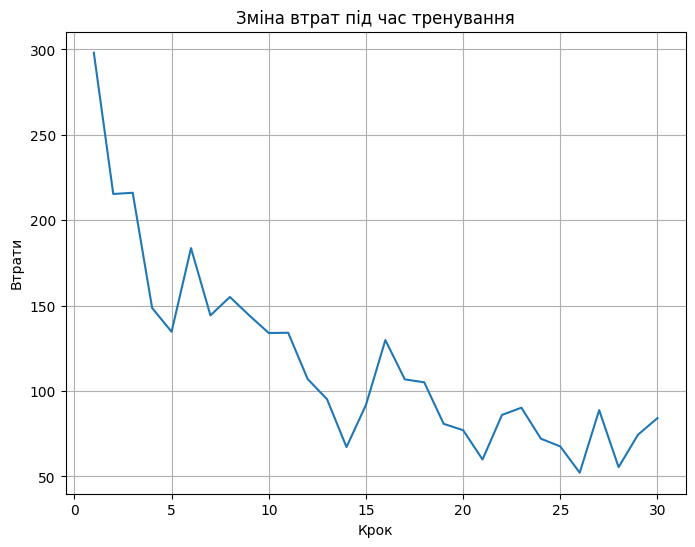

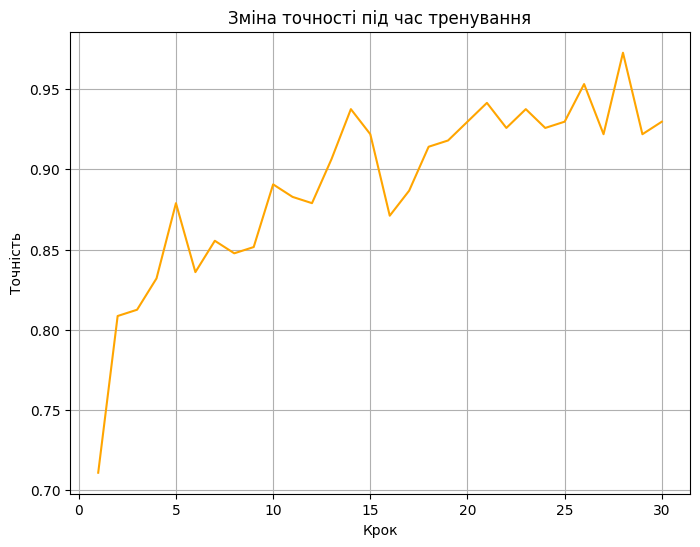

In [9]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(loss_history) + 1), loss_history, label='Loss')
plt.title('Зміна втрат під час тренування')
plt.xlabel('Крок')
plt.ylabel('Втрати')
plt.grid(True)
plt.show()

print('')

# Виведіть графік точності
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(accuracy_history) + 1), accuracy_history, label='Accuracy', color='orange')
plt.title('Зміна точності під час тренування')
plt.xlabel('Крок')
plt.ylabel('Точність')
plt.grid(True)
plt.show()

In [10]:
# Передбачення для тестових даних
pred = neural_net(x_test)  # отримуємо передбачення для всіх тестових даних
y_pred_classes = np.argmax(pred.numpy(), axis=1)  # Перетворюємо передбачення на класи
y_true_classes = y_test                           # Істинні значення класів

# Обчислимо точність навченої нейромережі
test_accuracy = accuracy(pred, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Виводимо метрики якості для кожного класу
print(classification_report(y_true_classes, y_pred_classes))

Test Accuracy: 0.9079
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       980
           1       0.97      0.97      0.97      1135
           2       0.87      0.92      0.89      1032
           3       0.91      0.88      0.89      1010
           4       0.90      0.90      0.90       982
           5       0.89      0.86      0.87       892
           6       0.92      0.94      0.93       958
           7       0.93      0.90      0.92      1028
           8       0.85      0.89      0.87       974
           9       0.89      0.88      0.89      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



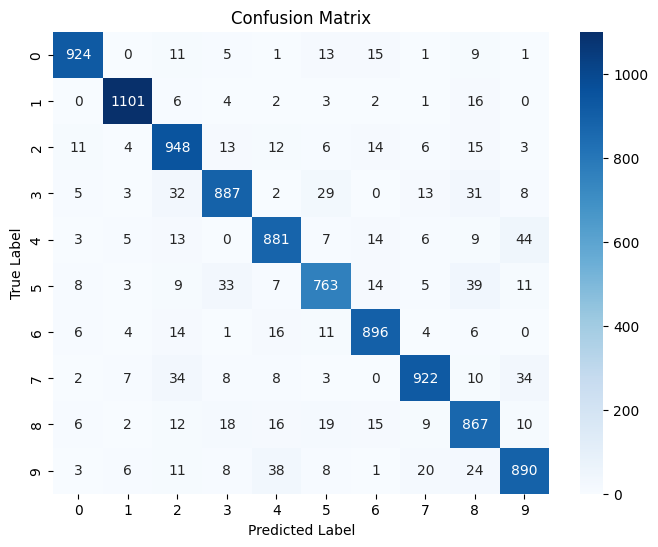

In [11]:
# Тестування на тестових даних: матриця плутанини
y_pred_classes = np.argmax(pred.numpy(), axis=1)  # Перетворюємо всі передбачення на класи
y_true_classes = y_test                           # Істинні значення класів, вже масив NumPy

# Обчислюємо матрицю помилок
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Виведемо матрицю помилок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
plt.title("Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

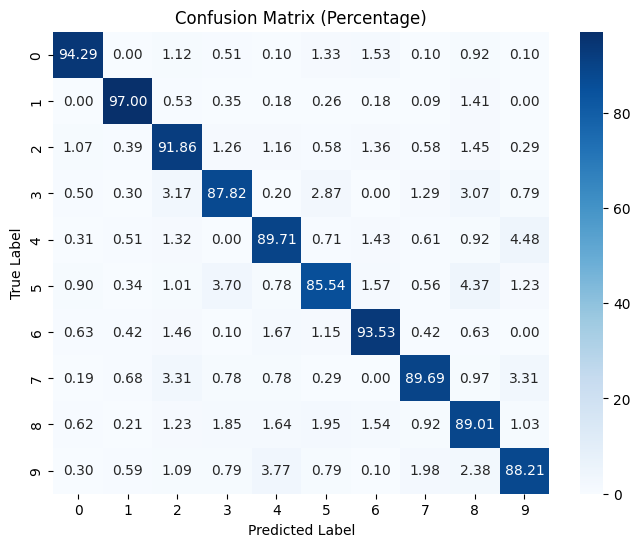

In [12]:
# Обчислюємо матрицю помилок
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Нормалізуємо матрицю плутанини для відображення відсотків
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Виводимо матрицю помилок у відсотках
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2f', cmap="Blues", xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
plt.title("Confusion Matrix (Percentage)")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [13]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

True: 6 Predict: 6 True
True: 2 Predict: 2 True
True: 3 Predict: 3 True
True: 7 Predict: 7 True
True: 2 Predict: 2 True
True: 2 Predict: 2 True
True: 3 Predict: 3 True
True: 4 Predict: 4 True
True: 7 Predict: 7 True
True: 6 Predict: 6 True


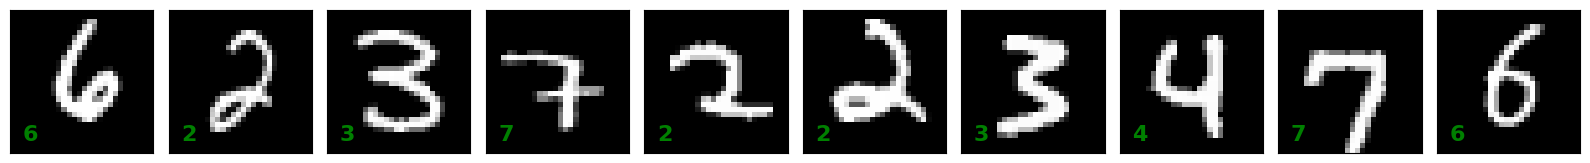

In [14]:
# Випадковий вибір 10 зображень з тестового набору
test_img = np.random.permutation(x_test.shape[0])[:10]              # Випадкове перемішування індексів і вибір перших 10
y_test_true = y_test[test_img]                                      # Вибір правильних міток для цих зображень
pred_data = [np.argmax(x) for x in neural_net(x_test[test_img])]    # Прогнозування класів для вибраних зображень

# Створення фігури з розмірами для 10 зображень
plt.figure(figsize=(16, 6))

# Цикл для виведення кожного зображення на екран
for i in range(10):
  correct = y_test_true[i] == pred_data[i]                            # Перевірка, чи правильно передбачено клас
  print(f"True: {y_test_true[i]} Predict: {pred_data[i]} {correct}")  # Виведення результатів

  # Виведення зображення в підпанелі (1 ряд, 10 стовпців)
  plt.subplot(1, 10, i + 1)
  plt.imshow(x_test[test_img[i]].reshape(28, 28), cmap='gray')        # Відображення зображення (28x28)
  plt.xticks([]), plt.yticks([])                                      # Вимикаємо осі для кращої візуалізації

  # Визначення кольору тексту: зелений для правильних передбачень, червоний — для неправильних
  color = "green" if correct else "red"
  plt.text(2, 25, pred_data[i], fontsize=16, color=color, fontweight="bold")  # Виведення передбаченого класу

# Забезпечує відображення зображень без зайвих проміжків між ними
plt.tight_layout()
plt.show()

**Висновки:**

1. Обчислена точність навченої нейромережі:

- Модель правильно класифікує 91% тестових зразків.

2. Аналіз матриці помилок:

- Найкраще модель передбачає класи: 0, 1, 2, 6 - для цих цифр нейромережа має найвищу точність передбачення.
- Число 5 класифікується найгірше, і модель правильно передбачає його в 85.5% випадків.

3. Точність на випадкових зображеннях:

- Точність на 5 випадкових зображеннях: 90%. Це показує, що на вибірці з кількох випадкових зображень точність передбачення незначно знижується, порівняно з загальною точністю на тестовому наборі даних.